# Generate samples

In this tutorial, we will introduce how to use Quantax to generate samples.

In the beginning, we prepare ground states of transverse-field Ising models from which we will generate samples.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import quantax as qtx
import matplotlib.pyplot as plt

lattice = qtx.sites.Square(4)

H0 = qtx.operator.Ising(h=1.0)
E0, wf0 = H0.diagonalize()
state0 = qtx.state.DenseState(wf0)

H1 = qtx.operator.Ising(h=3.0)
E1, wf1 = H1.diagonalize()
state1 = qtx.state.DenseState(wf1)

H2 = qtx.operator.Ising(h=10.0)
E2, wf2 = H2.diagonalize()
state2 = qtx.state.DenseState(wf2)

## Exact sampler

{py:class}`~quantax.sampler.ExactSampler` generates samples by sampling the full wavefunction. If the provided state is not a {py:class}`~quantax.state.DenseState`, it will generate a {py:class}`~quantax.state.DenseState` internally through forward pass. The sampler is defined below.

In [2]:
sampler0 = qtx.sampler.ExactSampler(state0, nsamples=1024)
sampler1 = qtx.sampler.ExactSampler(state1, nsamples=1024)
sampler2 = qtx.sampler.ExactSampler(state2, nsamples=1024)

Now we can generate samples.

In [3]:
samples0 = sampler0.sweep()
samples1 = sampler1.sweep()
samples2 = sampler2.sweep()

print(samples0)
print("spins shape", samples0.spins.shape)
print("psi shape", samples0.psi.shape)

Samples(spins=Array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1]], dtype=int8), psi=array([0.62184003, 0.00981954, 0.62184003, ..., 0.62184003, 0.62184003,
       0.62184003], shape=(1024,)), state_internal=None, reweight_factor=Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64))
spins shape (1024, 16)
psi shape (1024,)


The generated sample is a PyTree with 4 terms: `spins`, `psi`, `state_internal`, and `reweight_factor`. Beginners usually only need `spins` and `psi`, which correspond to the generated spin configurations $s$ and their wavefunctions $\psi(s)$. The probability of samples is given by $|\psi(s)|^2$

Let's check how magnetization changes by looking at

$$
\left< M^2 \right> = \left< \left( \frac{1}{N} \sum_i \sigma_i^z \right)^2 \right>.
$$

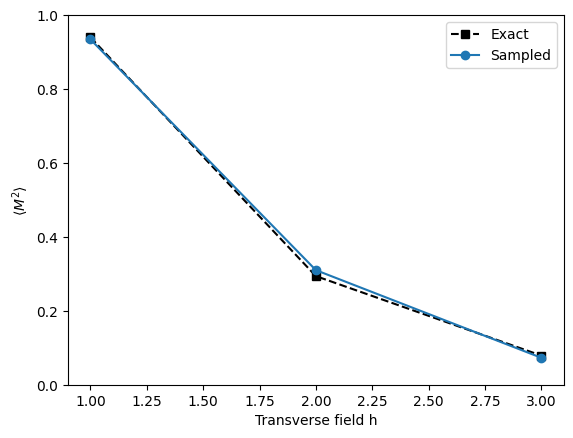

In [5]:
from quantax.operator import sigma_z

N = lattice.Nsites
M = sum(sigma_z(i) for i in range(N)) / N
M2 = M @ M

h = [1.0, 2.0, 3.0]

exactM2 = np.array([state0 @ M2 @ state0, state1 @ M2 @ state1, state2 @ M2 @ state2])
sampledM2 = np.array([
    M2.expectation(state0, samples0),
    M2.expectation(state1, samples1),
    M2.expectation(state2, samples2),
])

plt.plot(h, exactM2, 'ks--', label='Exact')
plt.plot(h, sampledM2, 'o-', label='Sampled')
plt.xlabel('Transverse field h')
plt.ylabel(r'$\langle M^2 \rangle$')
plt.ylim(0, 1)
plt.legend()
plt.show()

One can also show snapshots from generated samples.

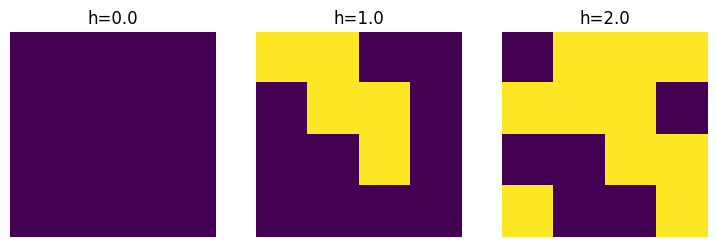

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(samples0.spins[0].reshape(4, 4))
axes[0].axis('off')
axes[0].set_title("h=0.0")

axes[1].imshow(samples1.spins[0].reshape(4, 4))
axes[1].axis('off')
axes[1].set_title("h=1.0")

axes[2].imshow(samples2.spins[0].reshape(4, 4))
axes[2].axis('off')
axes[2].set_title("h=2.0")

plt.show()

## Metropolis sampler

`ExactSampler` in general cannot be used in large systems, in which case we need metropolis samplers. Below we show how to create a `LocalFlip` sampler, which proposes new spin configurations by flipping spins locally.

In [7]:
sampler0 = qtx.sampler.LocalFlip(state0, nsamples=1024)
sampler1 = qtx.sampler.LocalFlip(state1, nsamples=1024)
sampler2 = qtx.sampler.LocalFlip(state2, nsamples=1024)

You might have noticed that it takes some time to construct the Metropolis sampler. It's because the spins stored in the sampler are thermalized during initialization. You can manually set an argument `thermal_steps=0` to initialize without thermalization, but please remember to thermalize spin configurations in the future.

The magnetization can be measured similarly.

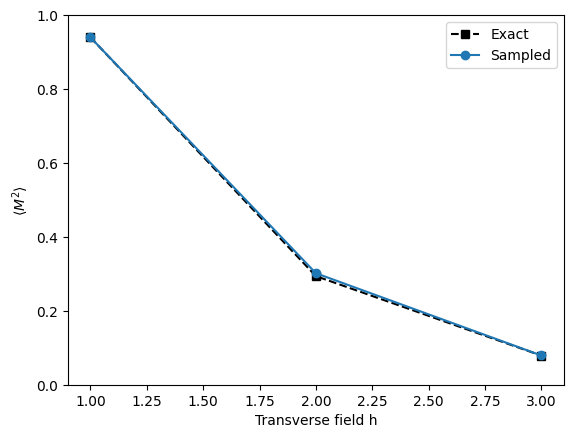

In [8]:
samples0 = sampler0.sweep()
samples1 = sampler1.sweep()
samples2 = sampler2.sweep()

exactM2 = np.array([state0 @ M2 @ state0, state1 @ M2 @ state1, state2 @ M2 @ state2])
sampledM2 = np.array([
    M2.expectation(state0, samples0),
    M2.expectation(state1, samples1),
    M2.expectation(state2, samples2),
])

plt.plot(h, exactM2, 'ks--', label='Exact')
plt.plot(h, sampledM2, 'o-', label='Sampled')
plt.xlabel('Transverse field h')
plt.ylabel(r'$\langle M^2 \rangle$')
plt.ylim(0, 1)
plt.legend()
plt.show()

By default, the initial thermalization takes 20 * N updates, and each sweep takes 2 * N updates. This is an empirical balance between efficiency and reliability. For better thermalization, one can specify `thermal_steps` and `sweep_steps` arguments in the initialization.

One can also customize metropolis samplers by an inheritance of `qtx.sampler.Metropolis`. Here we show an example of defining a sampler that flips all spins in a lattice.

In [ ]:
from functools import partial
from jaxtyping import Key


class FlipLattice(qtx.sampler.Metropolis):

    @partial(jax.jit, static_argnums=0)
    def propose(self, key: Key, old_spins: jax.Array):
        new_spins = -old_spins
        return new_spins

The sampler we just defined is obviously not ergodic. To make it work, we want to conbine it with `LocalFlip`. This can be done as shown below.

In [10]:
sampler_local = qtx.sampler.LocalFlip(state1, nsamples=896, thermal_steps=0)
sampler_global = FlipLattice(state1, nsamples=128, thermal_steps=0)
sampler_mix = qtx.sampler.MixSampler([sampler_local, sampler_global])

`sampler_mix` generates 896+128=1024 samples per sweep. In each proposal, there is 896/1024 chance to update all spin configurations by `LocalFlip`, and 128/1024 to update by `FlipLattice`. Here we check the magnetization to verify that the generated samples are still correct.

In [11]:
samples = sampler_mix.sweep()

print("Exact magnetization for h=1.0:", state1 @ M2 @ state1)
print("Sampled magnetization for h=1.0:", M2.expectation(state1, samples1))

Exact magnetization for h=1.0: 0.293884031111014
Sampled magnetization for h=1.0: 0.30169677734375
